# <center> EE4708: Data Analytics Laboratory </center>
# <center> Assignment 5: Random Forests </center>

## <center> Gautham Govind A: EE19B022 </center>

### Loading necessary packages

In [1]:
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import plot_tree

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix

from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
import xgboost as xgb

Setting suitable font size and figure size for plots:

In [2]:
plt.rcParams.update({'font.size': 17})
plt.rcParams['figure.figsize'] = (10, 7)

### Loading the dataset

A brief look at the dataset reveals that column names are actually missing from the excel file. We add them manually:

In [3]:
column_names = ['buying','maint','doors','persons','lug_boot','safety','target']
df = pd.read_excel('car_evaluation.xlsx', header = None, names = column_names)

In [4]:
df.head()

,buying,maint,doors,persons,lug_boot,safety,target
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   target    1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


Looks like we don't have any missing values.

###  Exploratory Data Analysis

We first look at how the target class is distributed:

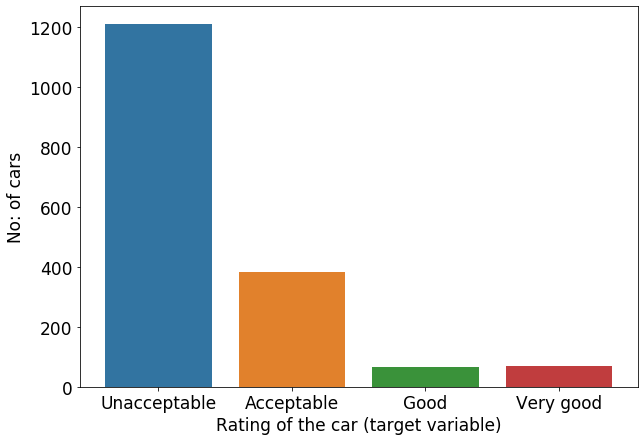

In [6]:
# We set the names of the classes as follows:
# unacc - Unacceptable
# acc   - Acceptable
# good  - Good
# vgood - Very good  
target_ratings = ['Unacceptable', 'Acceptable', 'Good', 'Very good']

ax = sns.countplot(data = df, x = 'target')
ax.set_xlabel('Rating of the car (target variable)')
ax.set_ylabel('No: of cars')
ax.set_xticklabels(target_ratings)
plt.autoscale()
plt.savefig("Figures/target_dist.png", bbox_inches = "tight")

The number of cars belonging to the target class 'unacc' are much higher than other categores. Hence, our dataset is inherently skewed. We should keep this in mind while building the decision tree.

Clearly, we have only categorical variables. We analyze the impact of each variable on the target through countplots.

#### Buying Price

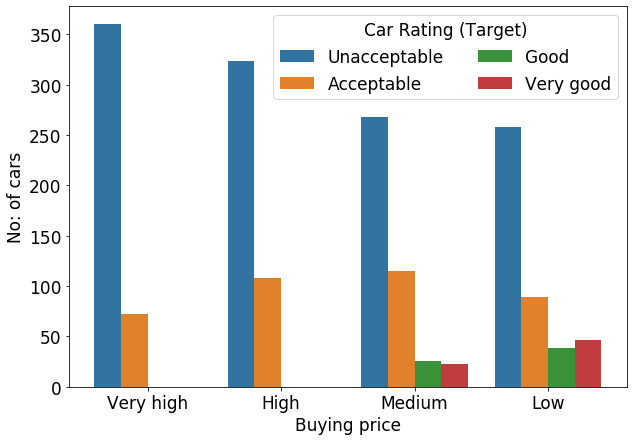

In [7]:
buying_price = ['Very high', 'High', 'Medium', 'Low']

ax = sns.countplot(data = df, x = 'buying', hue = 'target')
ax.set_xlabel('Buying price')
ax.set_ylabel('No: of cars')
ax.legend(target_ratings, ncol = 2, title = 'Car Rating (Target)')
ax.set_xticklabels(buying_price)
plt.autoscale()
plt.savefig("Figures/bp.png", bbox_inches = "tight")

Observations:
- Cars with high and very high have a large proportion of unacceptable vehicles
- Medium and low priced cars have representation from all categories

These observations make sense intuitively, because lower price vehicles will generally be more accessible to a larger section of the population.

#### Maintenance price

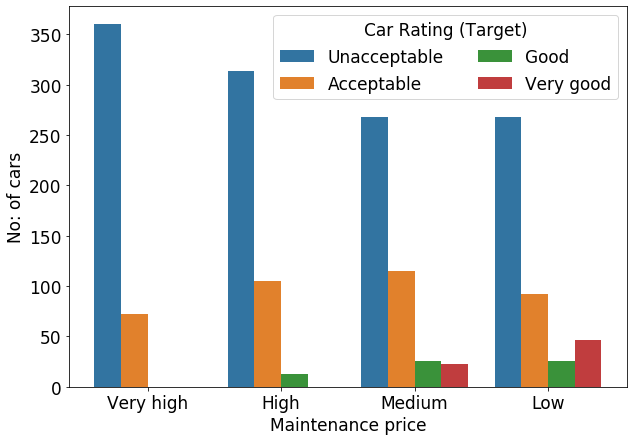

In [8]:
maintain_price = ['Very high', 'High', 'Medium', 'Low']

ax = sns.countplot(data = df, x = 'maint', hue = 'target')
ax.set_xlabel('Maintenance price')
ax.set_ylabel('No: of cars')
ax.legend(target_ratings, ncol = 2, title = 'Car Rating (Target)')
ax.set_xticklabels(maintain_price)
plt.autoscale()
plt.savefig("Figures/mp.png", bbox_inches = "tight")

The plot obtained is largely similar to the plot for buying price. This again makes sense intuitively since cars with high/very high maintenance charges would be mostly unacceptable to a large section of the population.

#### Number of Doors

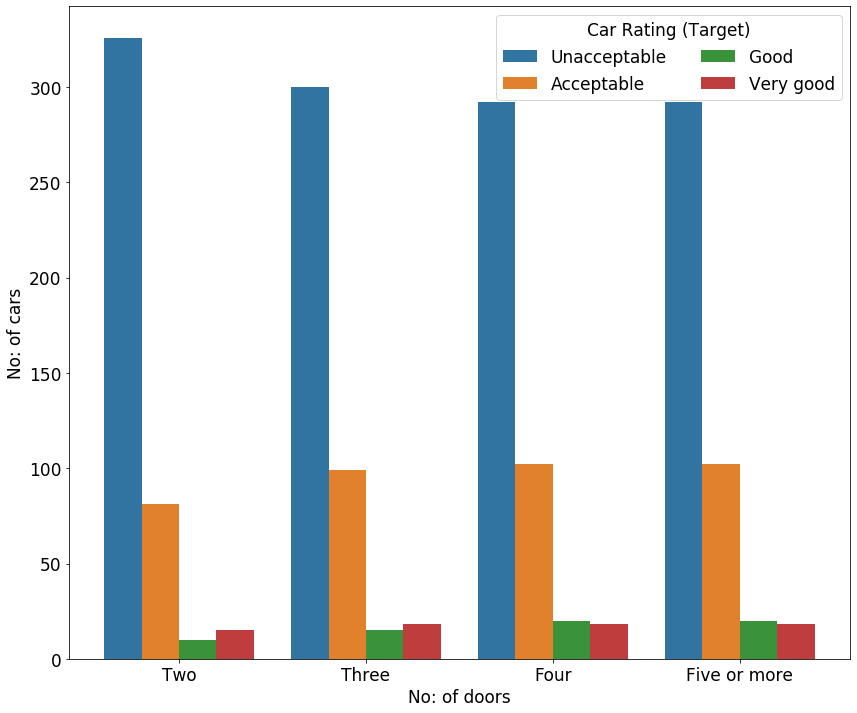

In [9]:
door_count = ["Two", 'Three', 'Four', 'Five or more']

plt.figure(figsize = (14, 12))
ax = sns.countplot(data = df, x = 'doors', hue = 'target')
ax.set_xlabel('No: of doors')
ax.set_ylabel('No: of cars')
ax.legend(target_ratings, ncol = 2, title = 'Car Rating (Target)')
ax.set_xticklabels(door_count)
plt.autoscale()
plt.savefig("Figures/nd.png", bbox_inches = "tight")

The distribution is similar for all categories of the variable respresenting the number of doors. This implies that no:of doors is not really a deciding factor as far as rating is concerned.

#### Passenger capacity

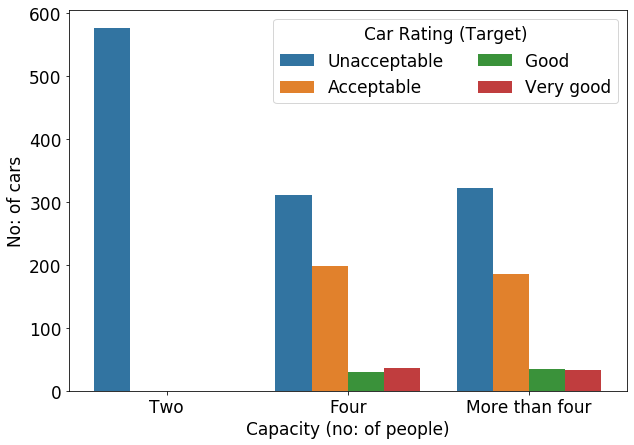

In [10]:
capacity = ['Two', 'Four', 'More than four']

ax = sns.countplot(data = df, x = 'persons', hue = 'target')
ax.set_xlabel('Capacity (no: of people)')
ax.set_ylabel('No: of cars')
ax.legend(target_ratings, ncol = 2, title = 'Car Rating (Target)')
ax.set_xticklabels(capacity)
plt.autoscale()
plt.savefig("Figures/cp.png", bbox_inches = "tight")

Observations:
- Cars that can accomodate only two people are all unacceptable
- Cars which can accomodate four and more than four have similar distriubtions

Intuitively, it seems fair that people find only cars which have atleast 4 seats to be acceptable.

#### Size of luggage boot

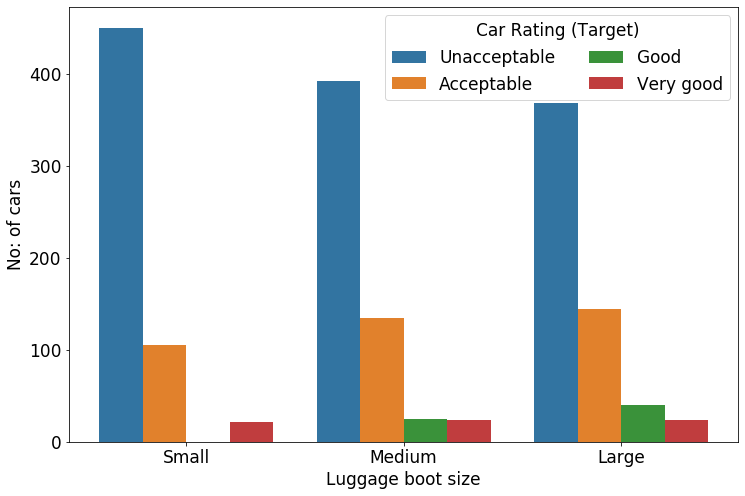

In [11]:
boot_size = ['Small', 'Medium', 'Large']

plt.figure(figsize = (12, 8))
ax = sns.countplot(data = df, x = 'lug_boot', hue = 'target')
ax.set_xlabel('Luggage boot size')
ax.set_ylabel('No: of cars')
ax.legend(target_ratings, ncol = 2, title = 'Car Rating (Target)')
ax.set_xticklabels(boot_size)
plt.autoscale()
plt.savefig("Figures/lgp.png", bbox_inches = "tight")

We observe that small-sized luggage boot has a relatively larger proportion of unacceptbale cars, which is what we expect inuitively anyway.

#### Safety rating

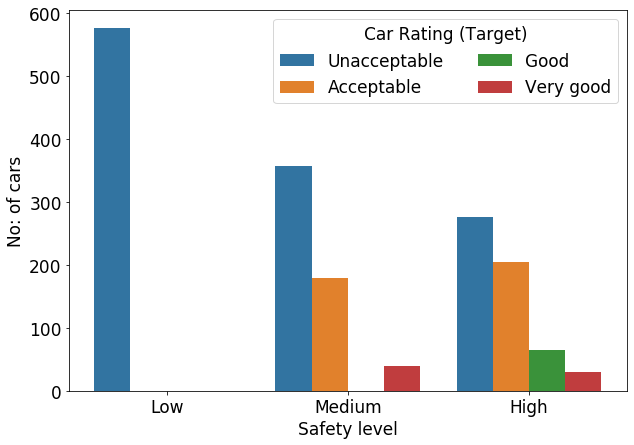

In [12]:
safety_lvl = ['Low', 'Medium', 'High']

ax = sns.countplot(data = df, x = 'safety', hue = 'target')
ax.set_xlabel('Safety level')
ax.set_ylabel('No: of cars')
ax.legend(target_ratings, ncol = 2, title = 'Car Rating (Target)')
ax.set_xticklabels(safety_lvl)
plt.autoscale()
plt.savefig("Figures/sfp.png", bbox_inches = "tight")

Observations:
- All low safety cars are unacceptable
- As safety level increases, proportion of unacceptbale cars decreases

Again this makes sense intuitively as people would prefer cars with high safety levels over low safety levels.

### Encoding the variables

Since all the variables are categorical, it is necessary to encode them.

We note that all the variables have an inherent ordering. Hence, it makes sense to use ordinal encoding.

In [13]:
# Buying price
bp_labels = {'low':0, 'med':1, 'high':2, 'vhigh':3}

# Maintenance price
mp_labels = {'low':0, 'med':1, 'high':2, 'vhigh':3}

# No: of doors
door_labels = {2:0, 3:1, 4:2, "5more":3}

# Passenger capacity
capacity_labels = {2:0, 4:1, 'more':2}

# Luggage boot size
boot_labels = {'small':0, 'med':1, 'big':2}

# Safety level
safety_labels = {'low':0, 'med':1, 'high':2}

# Target
target_labels = {'unacc':0, 'acc':1, 'good':2, 'vgood':3}

We perform label encoding:

In [14]:
df['buying'] = df['buying'].map(bp_labels)
df['maint'] = df['maint'].map(mp_labels)
df['doors'] = df['doors'].map(door_labels)
df['persons'] = df['persons'].map(capacity_labels)
df['lug_boot'] = df['lug_boot'].map(boot_labels)
df['safety'] = df['safety'].map(safety_labels)
df['target'] = df['target'].map(target_labels)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   buying    1728 non-null   int64
 1   maint     1728 non-null   int64
 2   doors     1728 non-null   int64
 3   persons   1728 non-null   int64
 4   lug_boot  1728 non-null   int64
 5   safety    1728 non-null   int64
 6   target    1728 non-null   int64
dtypes: int64(7)
memory usage: 94.6 KB


### Splitting dataset into training, validation and test sets

In [16]:
X = df.drop('target', axis = 1)
y = df['target']

Train - (Val+Test) split:

In [17]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size = 0.4, random_state = 42, stratify = y)

We ensure that target class proportion is preserved.

In [18]:
(y_train == 0).sum()/len(y_train)

0.7007722007722008

In [19]:
(y_val_test == 0).sum()/len(y_val_test)

0.6994219653179191

Val - Test split:

In [20]:
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size = 0.5, random_state = 42, stratify = y_val_test)

We ensure that target class proportion is preserved.

In [21]:
(y_val == 0).sum()/len(y_val)

0.6994219653179191

In [22]:
(y_test == 0).sum()/len(y_test)

0.6994219653179191

Displaying the dimensions:


In [23]:
print("Training set:", X_train.shape)
print("Validation set:", X_val.shape)
print("Test set:", X_test.shape)

Training set: (1036, 6)
Validation set: (346, 6)
Test set: (346, 6)


Making a combined training set for use after validation:

In [24]:
X_train_full = pd.concat([X_train, X_val])
y_train_full = np.concatenate((y_train, y_val),axis= 0)

X_train_full.reset_index(drop = True, inplace  = True)

#### Implementing ensemble methods

#### (i) Bagging

Bagging involves taking a number of decision trees, each trained without any random feature selection. We grid search for the number of trees.

Note that the only downside to having a higher number of trees is computational complexity; increaasing number of trees in no way degrades performance of the model.

We use bootstrapping with two-thirds of the training data being used for each tree.

In [25]:
clfs_bagged = [] 
no_of_trees = range(10,1000,10)

for count in no_of_trees:
    clf_bag = RandomForestClassifier(class_weight = 'balanced', 
                                    random_state = 42, n_estimators = count,
                                    oob_score = False, max_samples = 0.66, max_features = None, n_jobs = -1) 
    clf_bag.fit(X_train, y_train)
    clfs_bagged.append(clf_bag)

In [26]:
val_scores_bag = [f1_score(clf_bag.predict(X_val), y_val, average = 'weighted') for clf_bag in clfs_bagged]

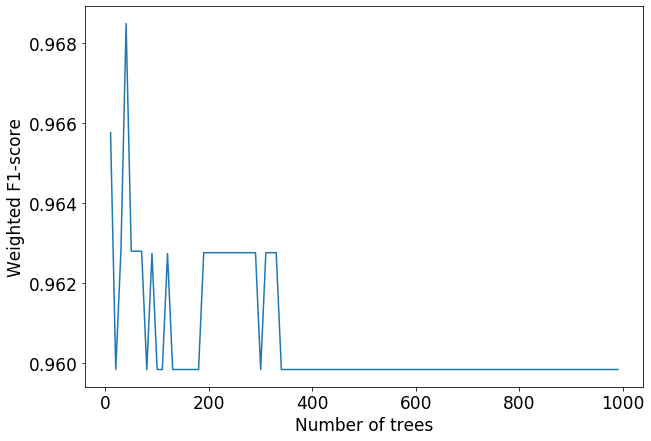

In [27]:

plt.plot(no_of_trees, val_scores_bag)
plt.xlabel("Number of trees")
plt.ylabel("Weighted F1-score")
plt.savefig("Figures/bag_num.png", bbox_inches = 'tight')

The score stabilizes after 400 trees. So we choose the number of trees to be 400.

Metrics for this case:

In [28]:
cr_bag = classification_report(y_val, clfs_bagged[no_of_trees.index(400)].predict(X_val), output_dict=True)
pd.DataFrame(cr_bag).loc[:, ['macro avg', 'weighted avg']][:-1]

,macro avg,weighted avg
precision,0.922041,0.959164
recall,0.915982,0.959538
f1-score,0.918912,0.959244


#### (ii) Random forest

We take the number of trees to be 400 from the previous analysis. We grid search for the number of features to be taken during random feature sampling. Since the total number of features is only 6, we search for all possible values:

In [29]:
num_feat_list = list(range(1, 7))
clfs_rf = []

for num_feat in num_feat_list:
    clf_rf = RandomForestClassifier(class_weight = 'balanced', 
                                    random_state = 42, n_estimators = 400,
                                    oob_score = False, max_samples = 0.66, max_features = num_feat, n_jobs = -1) 
    clf_rf.fit(X_train,y_train)
    clfs_rf.append(clf_rf)


In [30]:
val_scores_rf = [f1_score(clf_rf.predict(X_val), y_val, average = 'weighted') for clf_rf in clfs_rf]

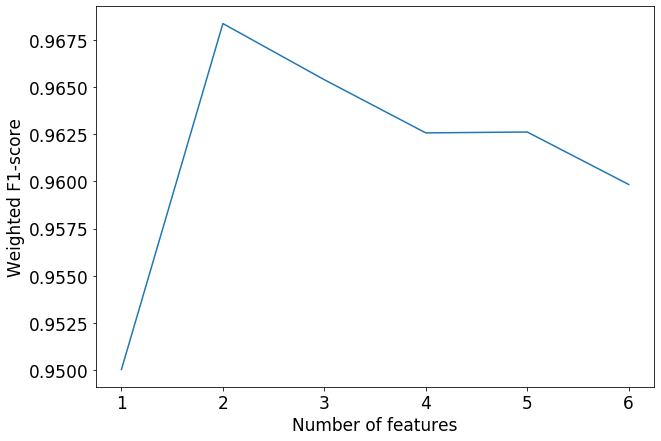

In [31]:
plt.plot(num_feat_list, val_scores_rf)
plt.xlabel("Number of features")
plt.ylabel("Weighted F1-score")
plt.savefig("Figures/rf_num.png", bbox_inches = 'tight')

We get a peak for number of features equal to 2. We choose this value.

In [32]:
cr_rf = classification_report(y_val, clfs_rf[num_feat_list.index(2)].predict(X_val), output_dict=True)
pd.DataFrame(cr_rf).loc[:, ['macro avg', 'weighted avg']][:-1]

,macro avg,weighted avg
precision,0.941189,0.968033
recall,0.925722,0.968208
f1-score,0.933149,0.968068


This model clearly outperforms the bagged model. Hence, we choose random forest with max features at each split set to 2.

We train it on the whole training data:

In [33]:
clf_best = RandomForestClassifier(class_weight = 'balanced', 
                                random_state = 42, n_estimators = 400,
                                oob_score = False, max_samples = 0.66, max_features = 2, n_jobs = -1) 
clf_best.fit(X_train_full, y_train_full)

RandomForestClassifier(class_weight='balanced', max_features=2,
                       max_samples=0.66, n_estimators=400, n_jobs=-1,
                       random_state=42)

Metrics and Confusion matrix for final model:

In [34]:
cr_final = classification_report(y_test, clf_best.predict(X_test), output_dict=True)
pd.DataFrame(cr_final).loc[:, ['macro avg', 'weighted avg']][:-1]

,macro avg,weighted avg
precision,0.959375,0.986597
recall,0.958439,0.985549
f1-score,0.956164,0.985557


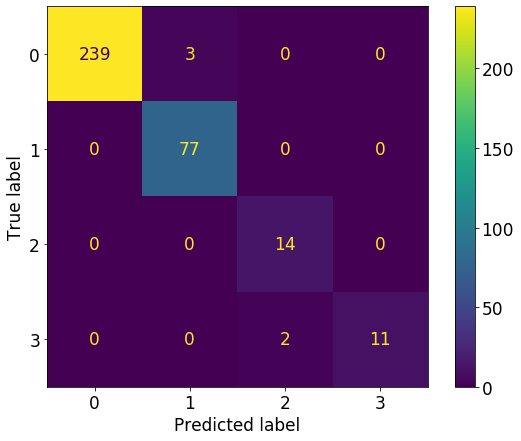

In [35]:
plot_confusion_matrix(clf_best, X_test, y_test)
plt.grid(False)
plt.savefig('Figures/cfmatrix')

We can see the importance of features through feature importance scores:

In [36]:
feature_scores = pd.Series(clf_best.feature_importances_, index=X_train_full.columns).sort_values(ascending=False)
print(feature_scores)

safety      0.272259
buying      0.193754
maint       0.172299
persons     0.151111
lug_boot    0.142663
doors       0.067915
dtype: float64


Safety is the most important feature, whereas no: of doors is the least important feature, which agrees with our initial exploratory analysis

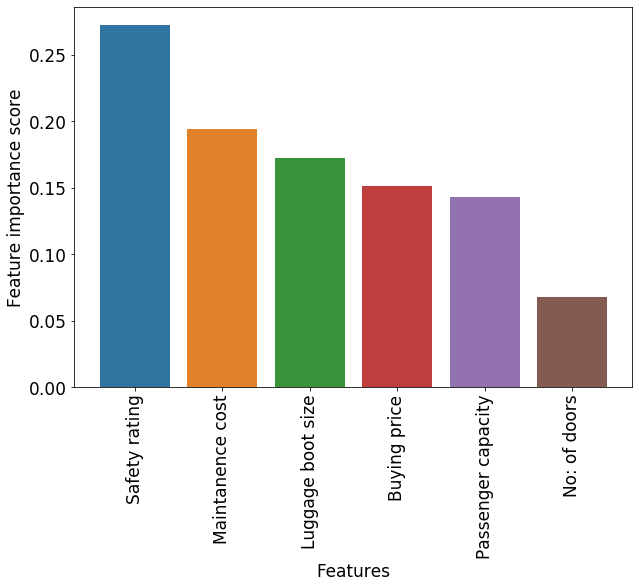

In [37]:
ax = sns.barplot(x = feature_scores.index, y = feature_scores, orient='v')
ax.set_xlabel('Features')
ax.set_ylabel('Feature importance score')
ax.set_xticklabels(['Safety rating', 'Maintanence cost', 'Luggage boot size', 'Buying price', 'Passenger capacity', 'No: of doors'])
plt.xticks(rotation = 90)
plt.grid(False)
plt.autoscale()
plt.savefig('Figures/feature_imp.png', bbox_inches = "tight")

### Comparison with XGBoost

In [38]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [39]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [1.0],
        'max_depth': [4, 5, 6]
        }

In [40]:
xgb = XGBClassifier(learning_rate = 0.02, n_estimators = 1000, objective='binary:logistic',
                 nthread=1)

In [41]:
folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 10)

random_search = GridSearchCV(estimator = xgb, param_grid=params,  scoring='f1_weighted', n_jobs=-1, cv=skf.split(X_train_full,y_train_full), verbose=3)

start_time = timer(None) 
random_search.fit(X_train_full, y_train_full)
timer(start_time) 

Fitting 3 folds for each of 135 candidates, totalling 405 fits

 Time taken: 0 hours 3 minutes and 28.82 seconds.


In [42]:
print(random_search.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.5, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.02, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=1, nthread=1,
              num_parallel_tree=1, objective='multi:softprob', ...)


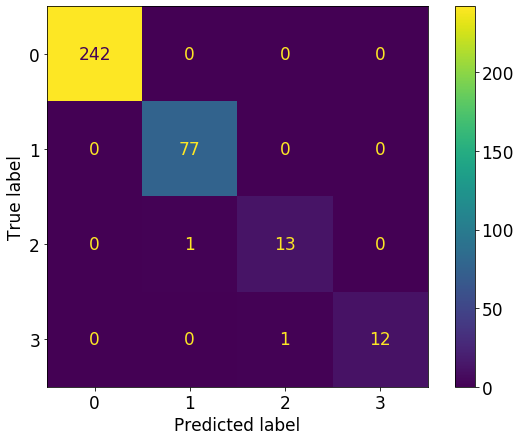

In [43]:
plot_confusion_matrix(random_search, X_test, y_test)
plt.grid(False)
plt.savefig('Figures/cfmatrix_xg.png')

In [44]:
cr_xg = classification_report(y_test, random_search.predict(X_test), output_dict=True)
pd.DataFrame(cr_xg).loc[:, ['macro avg', 'weighted avg']][:-1]

,macro avg,weighted avg
precision,0.978938,0.994257
recall,0.962912,0.994220
f1-score,0.970530,0.994171


In [45]:
feat_scores = random_search.best_estimator_.get_booster().get_score()
inv_dict = {}

for key, val in feat_scores.items():
    inv_dict[val] = key
    
feat_names = list(inv_dict.keys())
feat_names = sorted(feat_names)[::-1]

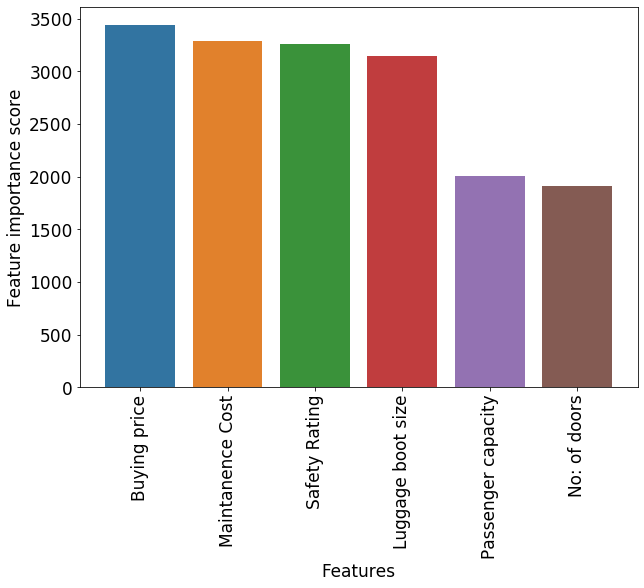

[CV 2/3] END colsample_bytree=1.0, gamma=0.5, max_depth=4, min_child_weight=1, subsample=0.8;, score=0.974 total time=   9.3s
[CV 3/3] END colsample_bytree=1.0, gamma=0.5, max_depth=4, min_child_weight=10, subsample=0.6;, score=0.958 total time=   2.3s
[CV 1/3] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.972 total time=   3.3s
[CV 1/3] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.956 total time=   2.8s
[CV 2/3] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.967 total time=   2.8s
[CV 1/3] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=10, subsample=1.0;, score=0.937 total time=   2.4s
[CV 3/3] END colsample_bytree=1.0, gamma=0.5, max_depth=6, min_child_weight=1, subsample=0.8;, score=0.983 total time=   3.7s
[CV 2/3] END colsample_bytree=1.0, gamma=0.5, max_depth=6, min_child_weight=5, subsample=0.8;, score=0.967 total tim

[CV 3/3] END colsample_bytree=1.0, gamma=0.5, max_depth=4, min_child_weight=1, subsample=0.8;, score=0.976 total time=   4.5s
[CV 1/3] END colsample_bytree=1.0, gamma=0.5, max_depth=4, min_child_weight=5, subsample=0.6;, score=0.952 total time=   1.6s
[CV 3/3] END colsample_bytree=1.0, gamma=0.5, max_depth=4, min_child_weight=5, subsample=0.6;, score=0.974 total time=   2.2s
[CV 3/3] END colsample_bytree=1.0, gamma=0.5, max_depth=4, min_child_weight=5, subsample=1.0;, score=0.974 total time=   2.3s
[CV 1/3] END colsample_bytree=1.0, gamma=0.5, max_depth=4, min_child_weight=10, subsample=1.0;, score=0.933 total time=   2.1s
[CV 3/3] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=1, subsample=0.8;, score=0.983 total time=   3.4s
[CV 1/3] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.963 total time=   2.7s
[CV 3/3] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.952 total tim

[CV 1/3] END colsample_bytree=1.0, gamma=0.5, max_depth=4, min_child_weight=1, subsample=1.0;, score=0.963 total time=   6.0s
[CV 1/3] END colsample_bytree=1.0, gamma=0.5, max_depth=4, min_child_weight=5, subsample=0.8;, score=0.956 total time=   2.1s
[CV 2/3] END colsample_bytree=1.0, gamma=0.5, max_depth=4, min_child_weight=5, subsample=1.0;, score=0.955 total time=   2.3s
[CV 3/3] END colsample_bytree=1.0, gamma=0.5, max_depth=4, min_child_weight=10, subsample=0.8;, score=0.967 total time=   2.2s
[CV 1/3] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=1, subsample=1.0;, score=0.978 total time=   3.1s
[CV 2/3] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.954 total time=   2.8s
[CV 1/3] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.940 total time=   2.5s
[CV 3/3] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=10, subsample=1.0;, score=0.961 total ti

[CV 3/3] END colsample_bytree=1.0, gamma=0.5, max_depth=4, min_child_weight=1, subsample=0.6;, score=0.974 total time=   9.1s
[CV 1/3] END colsample_bytree=1.0, gamma=0.5, max_depth=4, min_child_weight=10, subsample=0.6;, score=0.940 total time=   2.3s
[CV 3/3] END colsample_bytree=1.0, gamma=0.5, max_depth=4, min_child_weight=10, subsample=1.0;, score=0.945 total time=   2.1s
[CV 2/3] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=1, subsample=1.0;, score=0.974 total time=   3.1s
[CV 3/3] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.974 total time=   2.9s
[CV 2/3] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.907 total time=   2.5s
[CV 2/3] END colsample_bytree=1.0, gamma=0.5, max_depth=6, min_child_weight=1, subsample=0.6;, score=0.974 total time=   3.7s
[CV 1/3] END colsample_bytree=1.0, gamma=0.5, max_depth=6, min_child_weight=5, subsample=0.6;, score=0.956 total ti

In [49]:
ax = sns.barplot(x = [inv_dict[el] for el in feat_names], y = feat_names, orient='v')
ax.set_xlabel('Features')
ax.set_ylabel('Feature importance score')
ax.set_xticklabels(['Buying price',  'Maintanence Cost', 'Safety Rating', 'Luggage boot size', 'Passenger capacity', 'No: of doors'])
plt.xticks(rotation = 90)
plt.grid(False)
plt.autoscale()
plt.savefig('Figures/feature_imp_xg.png', bbox_inches = "tight")